# GSA - Genetic Stability Analyzer
The GSA is a program used to test various machine learning algorithms used for gene expression classification.  This notebook describes the implementation in detail and how to run.  For pure python files see the `main/Python` directory.  

Gene expression classification is a common technique used to determine classes of gene expressions (e.g. whether an expression is cancerous or not).  Various classifiers can be used, with a few  listed here:

 1. [K-nearest Neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)
 2. [Suport Vector Machine](https://en.wikipedia.org/wiki/Support_vector_machine#Linear_SVM)
 3. [Random Forest](https://en.wikipedia.org/wiki/Random_forest)
 4. [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
 5. [Network-based](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4214593/)
 
A question of note for all classifiers is how accurate are they when the gene expression data is perturbed.  At what point will perturbed gene expression data be unable to be classified accurately?  This program attempts to answer this question for each of the classifiers listed above.  It can be extended with more classifiers and perturbation methods.

### Libraries
Must be pre-installed.  It is recommended to use a [virtual environment](https://docs.python.org/3/tutorial/venv.html).

In [3]:
import numpy as np
import os as os
from typing import Optional
from random import sample, choice, uniform
from os import path, getcwd, makedirs
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import StratifiedKFold
from collections import Counter
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import lsqr
from math import sqrt, floor
from sklearn import svm
from multiprocessing import Pool, cpu_count
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

/Users/terek/.virtualenvs/py370/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Methods and Classes
This section defines all classes and methods used.  The methods and classes for each .py file found in `main/Python` are described here.

### NBC.py
The NBC.py file contains an implmentation of the Network-based Classifier described by [Ahmet Ay et al](http://journals.sagepub.com/doi/abs/10.4137/CIN.S14025).  Two classes are used: `Model` and `NetworkBasedClassifier`.

Briefly, when the classifier is fit, a model is constructed for each class of the training data.  The model consists of a system of equations for each gene expression, derived from the gene's mostly closely correlated neighbors.  The equation for each gene takes the form:

\begin{equation*}
f_v^k = \sum \nolimits_{u \in V-v} (\alpha_{vu} S[u] )+ c_v
\end{equation*}

where $f_v^k$ is the function that returns a theoretical gene expression level of gene $v$ if it fell in class $k$. The coefficients and constant, $\alpha_{vu}$ and $c_v$ respectively, are precomputed from the training data. In this way, given a sample $S$, we can calculate the theoretical expression level of a gene from its neighbors, $S[u]$.

In [ ]:
class Model:
    """The model constructed for a given class"""

    def __init__(self, X, label, epsilon=0.8):
        """Initializes the model for a given class.

        :param X: Training data for model. If array or matrix, shape [n_samples, n_features].
        :param label: Class label for the data.
        :param epsilon: Correlation cutoff value.
        """
        self._label = label
        self.X = np.array(X)

        correlations = np.corrcoef(self.X, y=None, rowvar=False)

        # Note: the mask is the graph.
        self.mask = (np.absolute(correlations) > epsilon)
        print(np.sum(self.mask[0]))

        pool = Pool(processes=cpu_count())
        self.coefficients = pool.starmap(self.solver,
                                         [(gene, self.mask[gene], self.X) for gene in range(len(correlations))])
        pool.terminate()

        self.coefficients = np.array(self.coefficients)
        print("NBC Model constructed.")

    @staticmethod
    def solver(gene, mask, X):
        """Uses least-square solver to compute coefficients for Ax=b, where
        A is an equation list created from the neighbors of a gene and b is
        the value of the gene.

        :param gene: The index of the gene to be solved for.
        :param mask: The correlation mask for the gene.
        :param X: The training samples.
        :return: The coefficients of the equation (x) in Ax=b
        """
        A = []
        b = []
        for sample in X:
            neighbors = [sample[neighbor] if (mask[neighbor] and (gene != neighbor))
                         else 0
                         for neighbor in range(len(mask))]
            neighbors.append(1)
            A.append(neighbors)
            b.append(sample[gene])
        A = np.array(A)
        b = np.array(b)
        x = lsqr(A, b)[0]
        return x.tolist()

    def expression(self, sample):
        """Returns a hypothetical expression level for a given sample.

        :param sample: Test sample
        :return: The hypothetical expression level of a given sample.
        """
        expression = []
        for gene in range(len(self.coefficients)):
            level = 0  # the expression level of a gene
            for neighbor in range(len(self.mask) - 1):
                level += self.coefficients[gene][neighbor] * sample[neighbor]
            level += self.coefficients[gene][len(self.mask)]
            expression.append(level)
        return np.array(expression)

    def label(self):
        """Returns the class label of the model.

        :return: The class label of the model.
        """
        return self._label


class NetworkBasedClassifier:
    """Classifier implementing the Network-based Classifier."""

    def __init__(self, epsilon=0.8):
        """Initializes the classifier.

        :param epsilon: epsilon value correlation cutoff.
        """
        self.models = []
        self.epsilon = epsilon

    def fit(self, X, y):
        """Fit the model using X as training data and y as target values.

        :param X: Training data. If array or matrix, shape [n_samples, n_features].
        :param y: Target values of shape = [n_samples]
        """
        self.models = []
        y = np.array(y)
        X = np.array(X)
        for label in Counter(y):
            a_class = np.where(y == label)
            self.models.append(Model([X[i] for i in a_class[0]], label, self.epsilon))

    def predict(self, X):
        """Predict the class labels for the provided data.

        :param X: Test samples.
        :return: Class labels for each data sample.
        """
        pool = Pool(processes=cpu_count())
        classifications = pool.map(self.classification, [sample for sample in X])
        pool.terminate()
        return classifications

    def score(self, X, y):
        """Returns the mean accuracy on the given test data and labels.

        :param X: Test samples.
        :param y: True labels for X.
        :return: Mean accuracy of self.predict(X) wrt. y.
        """
        y = np.array(y)
        X = np.array(X)
        correct = np.asarray(self.predict(X) == y)
        return np.sum(correct) / correct.shape[0]

    def classification(self, sample):
        """Returns the classification of the sample.

        :param sample: Test sample
        :return: The class label of the sample.
        """
        errors = []
        for model in self.models:
            error = sqrt(mean_squared_error(sample, model.expression(sample)))
            errors.append(error)
        min_index = errors.index(min(errors))
        return self.models[min_index].label()

### Estimatory.py
The estimator.py file holds a wrapper class, `Estimator`, for classifiers used in the stability analysis.

In [ ]:
class Estimator:
    """Describes the classifier chooser."""

    # Classifiers included:
    NBC = 0
    KNN = 1
    SVM = 2
    RF = 3
    NB = 4
    
    def __init__(self, _type, epsilon=0.8, k=1):
        """Initializes the classifier type.

        :param _type: The type of classifier to initialize.
        :param epsilon: Used in NBC (See nbc.py for more details).
        :param k: Used in KNeighborsClassifier (See documentation for more details).
        """
        self._type = _type

        # create the classifier
        if self.type == Estimator.NBC:
            self._classifier = NetworkBasedClassifier(epsilon)
            self._name = "NBC"
        elif self.type == Estimator.KNN:
            self._classifier = KNeighborsClassifier(k)
            self._name = "KNN"
        elif self.type == Estimator.SVM:
            self._classifier = svm.LinearSVC()
            self._name = "SVM"
        elif self.type == Estimator.RF:
            self._classifier = RandomForestClassifier()
            self._name = "RF"
        elif self.type == Estimator.NB:
            self._classifier = GaussianNB()
            self._name = "NB"
    
    @property
    def type(self):
        """Returns the type of the classifier.

        :return: The type of the classifier
        """
        return self._type
    
    @property
    def name(self):
        """Returns the name of the classifier.

        :return: The string name of the classifier.
        """
        return self._name
    
    def fit(self, X, y):
        """Fit the model using X as training data and y as target values.

        :param X: Training data. If array or matrix, shape [n_samples, n_features].
        :param y: Target values of shape = [n_samples]
        """
        self._classifier.fit(X, y)
        
    def score(self, X, y):
        """Returns the mean accuracy on the given test data and labels.

        :param X: Test samples
        :param y: True labels for X
        :return: Mean accuracy of self.predict(X) wrt. y.
        """
        return self._classifier.score(X, y)
        
    def predict(self, X):
        """Predict the class labels for the provided data.

        :param X: Test samples.
        :return: lass labels for each data sample.
        """
        return self._classifier.predict(X)

### Alter.py
The Alter.py file contains a class for creating an alteration strategy, `AlterStrategy`.  These methods are used to alter expressions and calculate accuracies of classifiers under the alteration condition.  There are currently four methods to alter expressions:

1. All - Alters all genes by some percent amount. Note that this actually selects a random expression level between low and high, with low and high increasing as percent increases.
2. Subset - Selects a subset of the genes using chi2 values and alters them between min and max gene level.
3. Random Subset - Selects a random subset of genes and alters them between min and max gene level.
4. Greedy - Uses a greedy strategy to select the top k genes that will produce the smallest accuracy score.

Note: cross-validation is different from the normal type in that the estimator is fit to correct data while the score is derived from altered data.

In [ ]:
class AlterStrategy:
    """Describes the alteration strategy used."""

    # Alter strategies included:
    ALL = 0
    SUB = 1
    RAND_SUB = 2
    GREEDY = 3

    def __init__(self, strategy, estimator: Estimator = None,
                 X=None, y=None, path=None):
        """Initializes an alter strategy.

        :param strategy: The strategy to be initialized.  e.g. AlterStrategy.ALL
        :param estimator: The estimator (aka classifier) tested by the strategy.
        :param X: The samples. [n_samples, n_features]
        :param y: The classes (aka labels for the samples. [n_samples]
        :param path: The path to a folder to save files to.
        """
        self._type = strategy
        self.estimator = estimator
        self.X = X
        self.y = y
        self.path = path

        if self.type == AlterStrategy.ALL:
            self._name = "ALL"
        elif self.type == AlterStrategy.SUB:
            self._name = "SUB"
        elif self.type == AlterStrategy.RAND_SUB:
            self._name = "RAND_SUB"
        elif self.type == AlterStrategy.GREEDY:
            self._name = "GREEDY"
            filename = '{}greedyRank.npy'.format(self.estimator.name)
            self.greedy_path = os.path.join(path, filename)
            # if a green rank doesn't exist, create one
            if not os.path.exists(self.greedy_path):
                print("GREEDY RANK INITIALIZER - THIS CAN TAKE A WHILE.")
                self.estimator.fit(X, y)
                to_choose = list(range(X.shape[1]))
                chosen = []
                for i in range(X.shape[1]):
                    accuracies = []
                    for idx in to_choose:
                        accuracies.append(self.accuracy(X, y, chosen, idx, self.estimator))
                    a = [x for _, x in sorted(zip(accuracies, to_choose))]
                    chosen.append(a[0])
                    to_choose.remove(a[0])
                np.save(self.greedy_path, chosen)

    @property
    def type(self):
        """Returns the type of the alteration strategy.

        :return: The type of the alteration strategy
        """
        return self._type

    @property
    def name(self):
        """Returns the name of the alteration strategy.

        :return: The string name of the alteration strategy.
        """
        return self._name

    @staticmethod
    def accuracy(X, y, chosen, idx_to_change, estimator: Estimator = None):
        """

        :param X: Test samples.
        :param y: True labels for X.
        :param chosen: Indices chosen so far
        :param idx_to_change: The index to change and test.
        :param estimator: The estimator (aka classifier) used to score the change.
        :return:
        """
        result = []
        for x in X:
            alt = np.copy(x)
            # alter prev chosen
            for i in chosen:
                alt[i] = 0
            # alter new gene
            alt[idx_to_change] = 0
            result.append(alt)
        result = np.array(result)
        return estimator.score(result, y)

    def alter(self, percent, X):
        """Alters a percent of the genes in the Test samples by the alteration strategy.
        Note: Because genes are already ordered by chi2 rank in the main program,
         we can choose top k to alter for the SUB strategy.

        :param percent: The percent of the subset to select from X
        :param X: Test samples.
        :return:
        """
        high = np.amax(self.X)
        low = np.amin(self.X)
        result = []
        k = floor(X[0].size * percent)
        if k <= 0:
            return X
        else:
            indices = []
            if self.type == AlterStrategy.RAND_SUB:
                indices = sample(range(X[0].size), k)
            elif self.type == AlterStrategy.SUB:
                indices = list(range(k))
            elif self.type == AlterStrategy.GREEDY:
                indices = np.load(self.greedy_path)[0:k:1]
            elif self.type == AlterStrategy.ALL:
                indices = list(range(X[0].size))
            for x in X:
                alt = np.copy(x)
                for i in indices:
                    if self.type == AlterStrategy.ALL:
                        offset = alt[i] * percent
                        low = alt[i] - offset
                        high = alt[i] + offset
                        alt[i] = choice([low, high])
                    else:
                        alt[i] = uniform(low, high)
                result.append(alt)
            return np.array(result)

    def cross_validate(self, percent=0, n_splits=10):
        """Performs cross validation of the alteration strategy used for a given
        percentage of genes in the test samples.

        :param percent: The percentage of genes to alter.
        :param n_splits: The number of folds.
        :return: The scores for a given percentage change.
        """
        scores = []
        skf = StratifiedKFold(n_splits)
        for train_index, test_index in skf.split(self.X, self.y):
            self.estimator.fit(self.X[train_index], self.y[train_index])
            accuracy = self.estimator.score(
                self.alter(percent, self.X[test_index]), self.y[test_index])
            scores.append(accuracy)
        return np.array(scores)

    def get_accuracies(self, step=0.05):
        """ Calculates the accuracies for [0,1] at increments of step.  This
        acts as a percentage of the genes to change from 0 to 100%.

        :param step: The step size for the accuracies.
        :return: The accuracies over all steps from 0 to 1
        """
        percents = np.arange(0, 1.01, step)
        accuracies = []
        deviations = []
        for percent in percents:
            scores = self.cross_validate(percent)
            accuracies.append(scores.mean())
            deviations.append(scores.std())
        accuracies = np.array(accuracies)
        deviations = np.array(deviations)
        result = np.column_stack((percents, accuracies, deviations))
        filename = '{}_{}_result.npy'.format(self.estimator.name, self.name)
        np.save(os.path.join(self.path, filename), result)
        return result

#### Helpers
In order to speed up processing time when running classification algorithms, it is often useful to choose only the "best" features (aka genes) to use.  There are various algorithms available to choose features, however here we use Chi2 to select the $k$ best features.  A good $k$ is important to prevent overfitting or underfitting of the models.  In practice, $k$ usually ranges from 50 to 300 for most genetic studies.

Note: this is in alter.py because at a future date it may be integrated.  Be aware that the selection is ranked by chi2 score, and this order is used by the SUB alteration strategy.

In [ ]:
def select_k_best(k, X, y):  
    """Selects the top k features, returning their indices in chi2 rank order.

    :param k: Number of top features to select.
    :param X: The training input samples.
    :param y: The target values (class labels in classification)
    :return: Ranked indices by score.
    """
    b = SelectKBest(chi2, k).fit(X, y)
    a = b.get_support(indices = True)
    a = [x for _,x in sorted(zip(b.scores_[a],a),reverse=True)]
    return np.array(a)

## Main Program
###### Enter the series and feature_size to use
Must be all upper case. e.g. `"GSE27562"`

In [ ]:
series = "GSE19804"
feature_size = 50

### Import Classes and Expressions
Load original data and select the features. This assumes SIT and a custome GSE script have been run to import data.

In [ ]:
notebook_dir = getcwd();
main_dir = path.dirname(path.dirname(notebook_dir))
load_path = path.join(main_dir, "GSE", series)
gsa_path = path.join(main_dir,"GSA", series, str(feature_size))
if not path.exists(gsa_path):
    makedirs(gsa_path)

y = np.loadtxt(path.join(load_path, "classes.txt"), dtype=np.str, delimiter="\t")
X = np.loadtxt(path.join(load_path, "expressions.txt"), delimiter="\t")

a = select_k_best(feature_size, X, y)
X = X[:, a]

np.save(path.join(gsa_path, "expressions.npy"), X)
np.save(path.join(gsa_path, "classses.npy"), y)

Calcualte stability of classifiers using various alter strategies.

In [ ]:
estimators = [Estimator(Estimator.KNN),
              Estimator(Estimator.SVM),
              Estimator(Estimator.RF),
              Estimator(Estimator.NB),
              Estimator(Estimator.NBC)]

for estimator in estimators:
    strategies = [AlterStrategy(AlterStrategy.ALL, estimator, X, y, gsa_path),
                  AlterStrategy(AlterStrategy.SUB, estimator, X, y, gsa_path),
                  AlterStrategy(AlterStrategy.RAND_SUB, estimator, X, y, gsa_path),
                  AlterStrategy(AlterStrategy.GREEDY, estimator, X, y, gsa_path)]
    for strategy in strategies:
        result = strategy.get_accuracies()

In [15]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

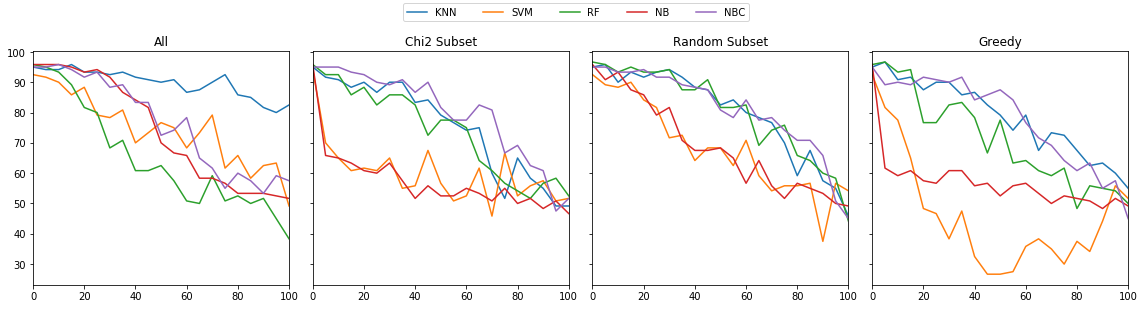

In [102]:
from matplotlib.pyplot import savefig, subplots, tight_layout


series = "GSE19804"
feature_size = 50

notebook_dir = getcwd();
main_dir = path.dirname(path.dirname(notebook_dir))
load_path = path.join(main_dir, "GSE", series)
gsa_path = path.join(main_dir,"GSA", series, str(feature_size))

classifiers = ['KNN', 'SVM', 'RF', 'NB', 'NBC']
strategies = ['ALL', 'SUB', 'RAND_SUB', 'GREEDY']
names = ['All', 'Chi2 Subset', 'Random Subset', 'Greedy']

fig, axs = subplots(1, len(strategies), figsize = (16,4), sharey = True)

i = 0
for strategy in strategies:
    for classifier in classifiers:
        data = np.load(path.join(gsa_path, "{}_{}_result.npy".format(classifier, strategy)))
        data = list(zip(*list(data)))
        axs[i].plot(np.arange(0,101,5), np.array(data[1])*100, label = classifier)
        axs[i].set_xlim(0, 100)
        axs[i].set_title(names[i])

    handles, labels = axs[i].get_legend_handles_labels()  
    i = i + 1

fig.legend(handles, labels, loc=3, bbox_to_anchor=(0.35, 1.0, 0.3, 0), 
           ncol=len(classifiers), mode="expand", borderaxespad=0.)

fig.tight_layout()

#savefig('foo.png', bbox_inches='tight')